# T03: Estrategia 01
---

A lo largo de este archivo se describe la ```estrategia 01``` utilizada para la clasificación individual de cada *patch* y, luego, el resultado obtenido al clasificar el conjunto de 10 imagenes provenientes de la radiografía.

---
## 1) Carga de Datos

In [151]:
import numpy as np
import os

# data directory path
DATADIR = 'data'

# carga de datos de training
x_training = np.load(os.path.join(DATADIR, 'training', 'dataset_features.npy'), allow_pickle=True)
label_training = np.load(os.path.join(DATADIR, 'training', 'dataset_labels.npy'), allow_pickle=True)
d_train = np.array([int(y[1:3]) for y in label_training])

# carga de datos de testing
x_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_features.npy'), allow_pickle=True)
label_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_labels.npy'), allow_pickle=True)
d_test = np.array([int(y[1:3]) for y in label_testing])

# features_label
flabels = np.load(os.path.join(DATADIR, 'flabels.npy'), allow_pickle=True)

### - Uso de caracteristicas:

Para esta primera estrategia solo se usarán las caracteristicas asociadas a la **geometria** dentro de la imagen y a los **descriptores** de esta.

In [170]:
use_columns = []
to_use = ['geo', 'des']
for label in flabels:  # nombre de la feature
    for ftype in to_use:  # nombres de las features que queremos usar
        if ftype in label:
            use_columns.append(*np.where(flabels == label)[0])  # agregamos el indice de la feature

print(f'Using only {len(use_columns)} features...')

# selecionamos solo esas columnas
x_train = x_training[:, use_columns]
x_test = x_testing[:, use_columns]

Using only 343 features...


## 2) Transformación y Selección de Características

- Dado la gran cantidad de caracteristicas que se obtienen (1000) de este tipo de datos vamos a reducir la dimensionalidad, antes de hacer selección y clasificación:

    1. Cleaning.
    2. Normalization (```mean```).
    3. PCA (```n_components=17```)
    3. Selection (```sfs``` con ```method=sp100``` y  ```n_features=7```).


### - Training:

In [171]:
from modules.feature_selection import sequential_forward_selection as sfs
from sklearn.preprocessing import StandardScaler
from pybalu.feature_selection import clean
from sklearn.decomposition import PCA

N_COMPONENTS = 15
FEATURES = 7

# Training: Cleaning
sclean = clean(x_train, show=False)
x_train_clean = x_train[:, sclean]
print('After Cleaning   : ' + str(x_train_clean.shape[1]) + ' features.')

# Training: Normalization
scaler = StandardScaler()
scaler.fit(x_train_clean)
x_train_norm = scaler.transform(x_train_clean)
print('Normalized       : ' + str(x_train_norm.shape[1]) + ' features.')

# Training: PCA transformation
pca = PCA(n_components=N_COMPONENTS)
pca.fit(x_train_norm)
x_train_pca = pca.transform(x_train_norm)
print('After PCA        : ' + str(x_train_pca.shape[1]) + ' features.')


# Training: Feature selection
selected = sfs(x_train_pca, d_train, n_features=FEATURES, method="sp100")
x_train_selected = x_train_pca[:, selected]
print('After Selection  : ' + str(x_train_selected.shape[1]) + ' features.')

After Cleaning   : 331 features.
Normalized       : 331 features.
After PCA        : 15 features.
After Selection  : 7 features.


### - Testing:

In [172]:
# Testing: Cleaning
x_test_clean = x_test[:, sclean]

# Testing: Normalization
x_test_norm = scaler.transform(x_test_clean)

# Testing: PCA tranformation
x_test_pca = pca.transform(x_test_norm)

# Testing: Feature selection
x_test_selected = x_test_pca[:, selected]

print('Testing ft: '+ str(x_test_selected.shape[1]) + ' from (' + str(x_test_selected.shape[0]) + ' samples)')

Testing ft: 7 from (1260 samples)


## 3) Classification:

- Para la clasificación se utilizó un algoritmos de *Naive Bayes* con ```kernel``` lineal.

### - Clasificador individual:

Accuracy:  0.716


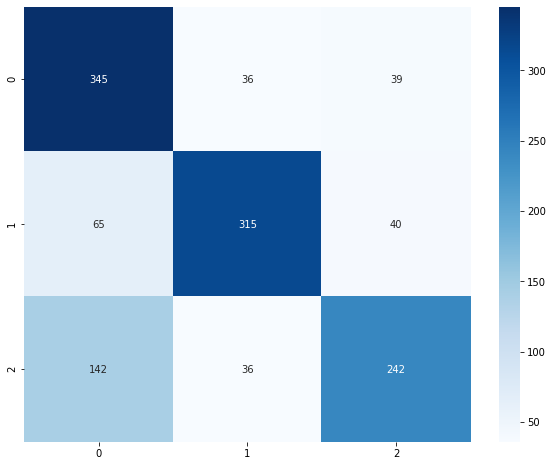

In [173]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

# Classification on Testing dataset
clf = GaussianNB()
clf.fit(x_train_selected, d_train)

predicted = clf.predict(x_test_selected)

acc = accuracy_score(d_test, predicted)
print('Accuracy: ', round(acc, 3))

cmatrix = confusion_matrix(d_test, predicted)


fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')

### - Clasificador Grupal:

In [147]:
# contadores por clase y tipo de votos
votes = {'00': {}, '01': {}, '02': {}}
for i in range(label_testing.shape[0]):
    label = label_testing[i]
    # si aún no se agrega esta clase
    if not label[4:8] in votes[label[1:3]].keys():
        votes[label[1:3]][label[4:8]] = [predicted[i]]
    else:
        votes[label[1:3]][label[4:8]].append(predicted[i])

In [148]:
# hacemos la clasificación en grupos vamos a contruir un predict and true value
group_predicted = []
group_true_value = []
for cnumber in votes:
    for gnumber in votes[cnumber]:
        group_true_value.append(int(cnumber))
        predicted_list = votes[cnumber][gnumber]
        group_predicted.append(max(set(predicted_list), key=predicted_list.count))
g_predicted = np.array(group_predicted)
g_test = np.array(group_true_value)

Accuracy:  0.754


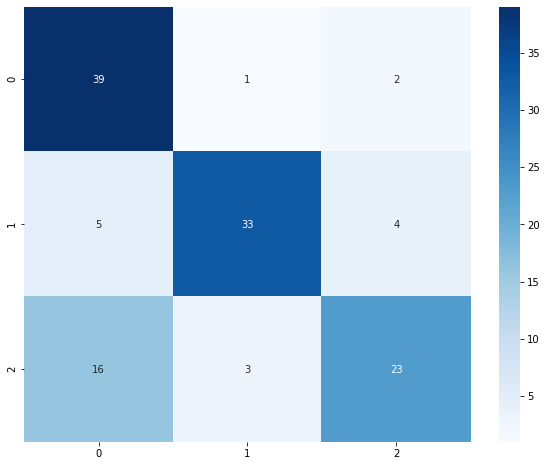

In [149]:
# estadisticas por grupos
g_acc = accuracy_score(g_test, g_predicted)
print('Accuracy: ', round(g_acc, 3))

g_cmatrix = confusion_matrix(g_test, g_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(g_cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')